# Navigation

---

## Brief introduction
In this notebook, I present my initial attempt to Project 1 in [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). It is basically an adoption of the solution to the Deep Q-Network section exercise.


### The model (the neural network)
_model.py_ is written in PyTorch, it defines the Neural Network. It is a deep network using 2 fully connected hidden layers (64 nodes each by default, but configurable through parameters _fc1_units_ and _fc2_units_ at initialisation stage) with ReLU activation. The input is the enviroment state (in this case a 1D-vector of size 37), while the output is the action (in this case a 1D-vector of size 4)

### The agent (the learning algorithm)
_dqn_agent.py_ defines the Agent, it learns with the Classic Deep Q-Learning technique, with Experience Replay and delayed Target Network update techniques
#### Experience Replay
Class _ReplayBuffer_ defines the buffer to cache the previous experience. "Global" parameter _BUFFER_SIZE_ defines the size of the casche. Note the cache is defined as a double-ended queue, where new data will push old data out of the cache. This is used for the experience replay feature, where the agent ramdomly sample the past experience for learning, which helps to break the staet-action correlation.
#### Double Q-Learning
Class _Agent_ defines two networks - one called local and another called target. The local network is used to estimate the Q value; while the target network is used to find the action that gives the maximum Q values. The local network parameters are updated as it learns through the experiences; while the target network's parameters update is delayed. This helps to break the co-movement between action and Q values and avoid overestimation. In particular, the target network's parameter udpate is performed by the _soft_update()_ method, which takes a weighted average of the local and target network parameters, i.e. the update of target parameters is "delayed" according to the weights.
#### Loss function and optimisation
The mean square error loss is used in conjunction with the Adam optimiser.


#### Hyperparameters
The following are the hyperparameters used

- _BUFFER_SIZE_ defines the replay buffer size, default to 1e5
- _BATCH_SIZE_ defines minibatch size in learning, defaults to 64
- _GAMMA_ defines the discount factor in expected reward calculation, defauls to 0.99
- _TAU_ defines the weights for soft update of target parameters, defaults to 1e-3
- _LR_ defines the learning rate, defaults to 5e-4
- _UPDATE_EVERY_ defines how often to update the network, defaults to 4

### Saving the trained model
The trained parameters are saved in the file _checkpoint.pth_

## Setting it up
We begin by importing some necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Loading the Banana Navigation enviroment by pointing the path to the EXE file in Windows.

In [2]:
env = UnityEnvironment(file_name=r"./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Setting the Environment **_brain_**.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

checking the enviroment

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Trying with an un-trained agent - it does not take any action at all...

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
i = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    i+=1
    if done:                                       # exit loop if episode finished
        break
print("Number of time steps: {}".format(i))
print("Score: {}".format(score))

Number of time steps: 300
Score: 0.0


## Training
Training the agent, score>=13 as success. It is usually solved within 500 episodes, the code below print out the learning progress in scores vs. episode, as well as the number of episode required to solve it. It also saves the trained model parameters in file _checkpoint.pth_.

In [6]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

def dqn(brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # Set the enviroment in training mode
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).item()
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(brain_name)

Episode 100	Average Score: 1.17
Episode 200	Average Score: 4.06
Episode 300	Average Score: 7.67
Episode 400	Average Score: 10.29
Episode 500	Average Score: 12.60
Episode 516	Average Score: 13.04
Environment solved in 416 episodes!	Average Score: 13.04


Visualise the score evolution

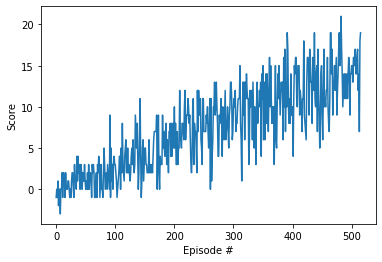

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## See trained Agent in action

In [9]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 14.0


close the environment.

In [13]:
env.close()

## Future Improvement

The model has achieved reasonale results. However, further optimisation is possible, including but not limited to the following.
- General neural network learning improvement techniques, for example dropout to avoid overfitting, etc.
- Adjustments to improve DQN, like Prioritised Experience Replay (see _Report_plus.ipynb_ for an attempt), Dueling DQN, A3C, Distributional DQN, Noisy DQN, etc
- [Generalization and Regularization in DQN](https://arxiv.org/abs/1810.00123)(the current envoriment summarise the graphic as 37 state values instead of pixel by pixel, which is already a form of generalisation).